In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [3]:
import numpy as np

# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Just use `fit` as usual
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=3)

Metal device set to: Apple M1 Pro
Epoch 1/3


2022-07-17 23:43:38.583566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-17 23:43:38.584075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-17 23:43:38.691657: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/32 [=============>................] - ETA: 0s - loss: 1.2435 - mae: 1.0156

2022-07-17 23:43:38.832598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step - loss: 1.0203 - mae: 0.8975
Epoch 2/3
32/32 [==============================] - 0s 4ms/step - loss: 0.4087 - mae: 0.5287
Epoch 3/3
32/32 [==============================] - 0s 4ms/step - loss: 0.2385 - mae: 0.3943


In [4]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")


class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = keras.losses.mean_squared_error(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        mae_metric.update_state(y, y_pred)
        return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, mae_metric]


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)

# We don't passs a loss or metrics here.
model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 0s 4ms/step - loss: 0.2910 - mae: 0.4374
Epoch 2/5
 1/32 [..............................] - ETA: 0s - loss: 0.2816 - mae: 0.4612

2022-07-17 23:46:24.519666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step - loss: 0.2145 - mae: 0.3688
Epoch 3/5
32/32 [==============================] - 0s 4ms/step - loss: 0.2080 - mae: 0.3632
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2009 - mae: 0.3575
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 0.1936 - mae: 0.3506


In [5]:
class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                sample_weight=sample_weight,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# You can now use sample_weight argument
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
sw = np.random.random((1000, 1))
model.fit(x, y, sample_weight=sw, epochs=3)

Epoch 1/3
24/32 [=====================>........] - ETA: 0s - loss: 0.1547 - mae: 0.4603

2022-07-17 23:48:10.898721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step - loss: 0.1438 - mae: 0.4422
Epoch 2/3
32/32 [==============================] - 0s 4ms/step - loss: 0.1083 - mae: 0.3805
Epoch 3/3
32/32 [==============================] - 0s 4ms/step - loss: 0.1047 - mae: 0.3757


In [6]:
class CustomModel(keras.Model):
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(loss="mse", metrics=["mae"])

# Evaluate with our custom test_step
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.evaluate(x, y)

32/32 [==============================] - 0s 3ms/step - loss: 0.4422 - mae: 0.5487


2022-07-17 23:48:32.214390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.44222337007522583, 0.548742949962616]

In [29]:
from tensorflow.keras import layers

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [30]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [31]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
gan.fit(dataset, epochs=20)

Epoch 1/20


2022-07-18 00:01:01.916385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1094/1094 [==============================] - 72s 65ms/step - d_loss: 0.4560 - g_loss: 1.4563
Epoch 2/20
1094/1094 [==============================] - 71s 65ms/step - d_loss: 0.6045 - g_loss: 1.0178
Epoch 3/20
1094/1094 [==============================] - 71s 65ms/step - d_loss: 0.6871 - g_loss: 0.8045
Epoch 4/20
1094/1094 [==============================] - 71s 65ms/step - d_loss: 0.6809 - g_loss: 0.8056
Epoch 5/20
1094/1094 [==============================] - 71s 65ms/step - d_loss: 0.6739 - g_loss: 0.8362
Epoch 6/20
1094/1094 [==============================] - 71s 65ms/step - d_loss: 0.6630 - g_loss: 0.8484
Epoch 7/20
1094/1094 [==============================] - 75s 69ms/step - d_loss: 0.6389 - g_loss: 0.8911
Epoch 8/20
1094/1094 [==============================] - 72s 66ms/step - d_loss: 0.6208 - g_loss: 0.9492
Epoch 9/20
1094/1094 [==============================] - 72s 65ms/step - d_loss: 0.5954 - g_loss: 0.9832
Epoch 10/20
1094/1094 [==============================] - 72s 65ms/step - d_

In [14]:
generator.predict()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [32]:
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
random_latent_vectors.shape

TensorShape([64, 128])

In [33]:
predictions = generator.predict(random_latent_vectors)
predictions.shape

2/2 [==============================] - 0s 15ms/step


2022-07-18 00:27:25.734812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(64, 28, 28, 1)

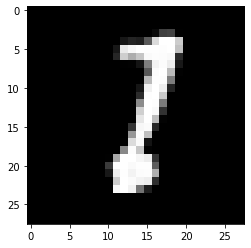

In [36]:
import matplotlib.pyplot as plt

plt.imshow(predictions[1], cmap='gray')

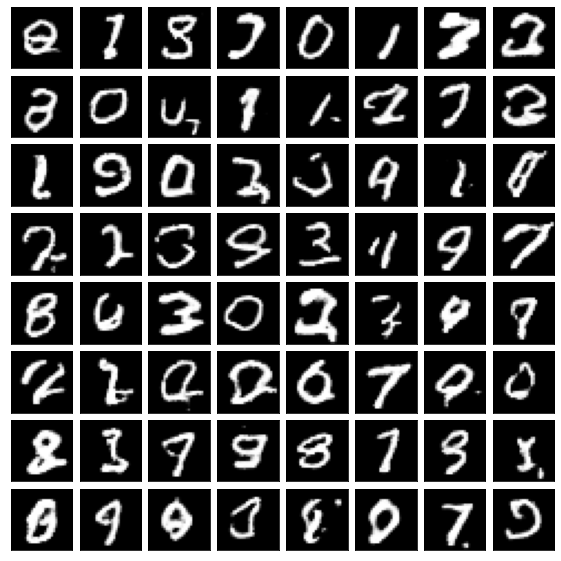

In [45]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [pred for pred in predictions]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])